# 2. Score classic methods

In [1]:
from common import score_models, load_predictions, load_trues
from metrics import recall

In [2]:
""" Compute intersection between correct prediction of two models """
def intersection_correct_predictions(trues:dict, preds1:dict, preds2:dict) -> float:
    matches = 0
    size = 0
    for k, trues_v in trues.items():
        if trues_v != []:
            match1 = set(dict.fromkeys(trues_v)) & set(dict.fromkeys(preds1[k]))
            match2 = set(dict.fromkeys(trues_v)) & set(dict.fromkeys(preds2[k]))
            matches += len(match1 & match2)
            size += 1
    return matches/size

In [3]:
import numpy as np
import matplotlib.pyplot as plt

""" Compute and plot an histogram of % of citations"""
def display_histogram(hist:list, bins:list) -> None:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(range(len(hist)),hist,width=0.95, align="edge", color='#18dcff') 
    for container in ax.containers:# Add bar labels
        ax.bar_label(container,fmt='%.0f%%', padding=3, fontweight="bold", fontsize="large", color='#18dcff')
    ax.set_xticks([0.5+i for i,j in enumerate(hist)])
    ax.set_xticklabels([f"[{bins[i]}:{bins[i+1]}]" for i,j in enumerate(hist)])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("Referenced papers", fontsize="x-large", fontfamily="Helvetica Neue")
    ax.set_ylabel("% of citations", fontsize="x-large", fontfamily="Helvetica Neue")
    ax.tick_params(axis='both', which='major', labelsize="x-large", labelfontfamily="Helvetica Neue", direction="out")
    plt.show()

""" Generate an histogram for citations values of predictions """
def generate_histogram_citations(preds, annotators_ids:list=[1,2,3]) -> list:
    citations_list = []
    for annotator_id in annotators_ids:
        for pred_citations in preds[f"A{annotator_id}"].values():
            citations_list = citations_list + pred_citations
    hist, bins = np.histogram(citations_list, [0, 10, 50, 100, 1000, max(citations_list)])
    hist = [(count / len(citations_list)) * 100 for count in hist]
    return hist, bins

In [4]:
""" Measure recall between a ground-thruth and predictions with reduced constraint on first author """ 
def recall_first_author(trues:list, preds:list) -> float:
    matches = [true for true in trues if true in preds]
    unmatched_preds = [pred for pred in preds if pred not in matches]
    unmatched_trues = [true for true in trues if true not in matches]
    
    for unmatched_true in unmatched_trues:
        for unmatched_pred in unmatched_preds:
            if unmatched_true["authors"][0] == unmatched_pred["authors"][0]:
                matches.append(unmatched_true)
                unmatched_preds.remove(unmatched_pred)
                break
    return len(matches)/len(trues)

""" Measure recall between a ground-thruth and predictions with reduced constraint on any author """ 
def recall_any_authors(trues:list, preds:list) -> float:
    matches = [true for true in trues if true in preds]
    unmatched_preds = [pred for pred in preds if pred not in matches]
    unmatched_trues = [true for true in trues if true not in matches]
    
    for unmatched_true in unmatched_trues:
        for unmatched_pred in unmatched_preds:
            if len(set(unmatched_true["authors"]) & set(unmatched_pred["authors"])):
                matches.append(unmatched_true)
                unmatched_preds.remove(unmatched_pred)
                break
    return len(matches)/len(trues)

## Classic methods comparison

In [5]:
trues = load_trues("../reading_lists.csv", keys=["id_title"], acl_only=True)
preds = load_predictions([
    "classic_methods/preds/semantic_scholar/any",
    "classic_methods/preds/semantic_scholar/acl",
    "classic_methods/preds/bm25",
    "classic_methods/preds/specter2"
], keys=["id_title"])

preds_names = [
    "Semantic Scholar (Any)",
    "Semantic Scholar (ACL)",
    "BM25",
    "SPECTER2"
]

table = score_models(trues, preds, preds_names, split_by_years=False); table 
#print(table.to_latex(float_format="{:0.1f}".format))

recall                                     ndcg  \
                              A1        A2         A3      Mean        A1   
Semantic Scholar (Any)  4.478147  3.816047   6.673190  4.989128  2.213700   
Semantic Scholar (ACL)  8.649706  6.242661  10.476190  8.456186  5.719130   
BM25                    8.873668  8.489889  11.156773  9.506777  5.722704   
SPECTER2                5.787671  5.676778   8.245864  6.570104  3.064759   

                                                           mrr            \
                              A2        A3      Mean        A1        A2   
Semantic Scholar (Any)  2.376716  3.852367  2.814261  2.483752  3.451022   
Semantic Scholar (ACL)  4.527250  7.462571  5.902984  8.065528  6.669928   
BM25                    5.105861  6.581614  5.803393  8.765831  5.929288   
SPECTER2                3.397064  4.709815  3.723880  3.333865  4.578341   

                                             
                               A3      Mean  
Semantic Scholar (Any)   5.403053  3.779275  
Semantic Scholar (ACL)  11.021418  8.585625  
BM25                     9.199094  7.964738  
SPECTER2                 5.763281  4.558496

## Intersection of correct prediction (BM25 vs SPECTER2)

In [6]:
bm25_preds, specter2_preds = load_predictions([
    "classic_methods/preds/bm25",
    "classic_methods/preds/specter2"
], keys=["id_title"])

(intersection_correct_predictions(trues, bm25_preds["A1"], specter2_preds["A1"]) +\
intersection_correct_predictions(trues, bm25_preds["A2"], specter2_preds["A2"]) +\
intersection_correct_predictions(trues, bm25_preds["A3"], specter2_preds["A3"])) /3

0.1050228310502283

## Citations differences analysis

In [7]:
trues = load_trues("../reading_lists.csv", keys=["id_title"], acl_only=True)
preds = load_predictions([
    "classic_methods/preds/semantic_scholar/any",
    "classic_methods/preds/semantic_scholar/acl",
    "classic_methods/preds/semantic_scholar/any_most_cited",
    "classic_methods/preds/semantic_scholar/acl_most_cited"
], keys=["id_title"])

preds_names = [
    "Semantic Scholar (Any)",
    "Semantic Scholar (ACL)",
    "Semantic Scholar (Any - Most Cited)",
    "Semantic Scholar (ACL - Most Cited)"
]

table = score_models(trues, preds, preds_names, split_by_years=False); table 
#print(table.to_latex(float_format="{:0.1f}".format))

recall                       \
                                            A1        A2         A3   
Semantic Scholar (Any)                4.478147  3.816047   6.673190   
Semantic Scholar (ACL)                8.649706  6.242661  10.476190   
Semantic Scholar (Any - Most Cited)   5.587084  4.774951   8.228963   
Semantic Scholar (ACL - Most Cited)  10.613177  5.936073  14.602087   

                                                    ndcg                      \
                                          Mean        A1        A2        A3   
Semantic Scholar (Any)                4.989128  2.213700  2.376716  3.852367   
Semantic Scholar (ACL)                8.456186  5.719130  4.527250  7.462571   
Semantic Scholar (Any - Most Cited)   6.196999  3.772837  3.512437  6.310157   
Semantic Scholar (ACL - Most Cited)  10.383779  7.287712  4.254474  9.869467   

                                                     mrr                       \
                                         Mean         A1        A2         A3   
Semantic Scholar (Any)               2.814261   2.483752  3.451022   5.403053   
Semantic Scholar (ACL)               5.902984   8.065528  6.669928  11.021418   
Semantic Scholar (Any - Most Cited)  4.531810   6.082644  4.998713  10.480045   
Semantic Scholar (ACL - Most Cited)  7.137218  10.981119  6.484611  13.297184   

                                                
                                          Mean  
Semantic Scholar (Any)                3.779275  
Semantic Scholar (ACL)                8.585625  
Semantic Scholar (Any - Most Cited)   7.187134  
Semantic Scholar (ACL - Most Cited)  10.254305

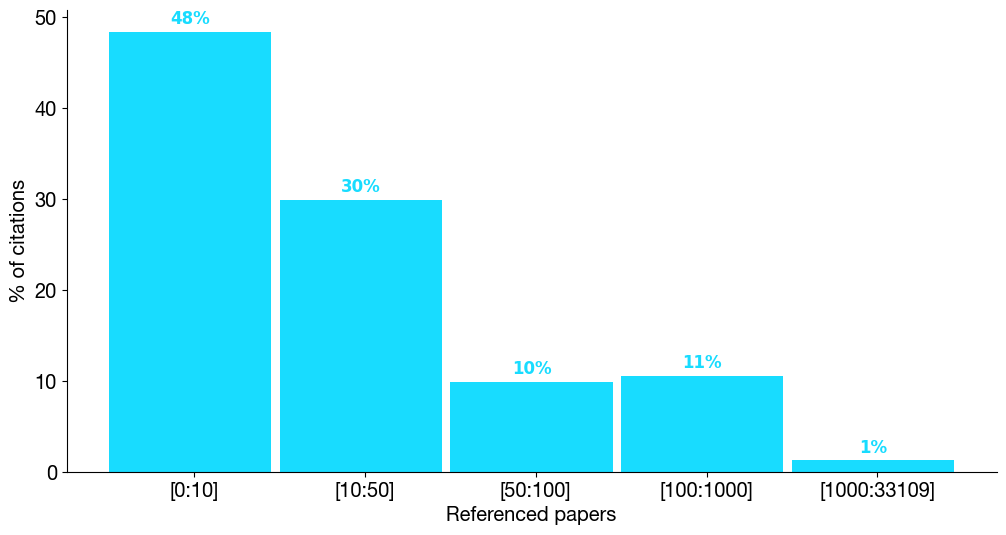

In [8]:
display_histogram(*generate_histogram_citations(load_predictions(["classic_methods/preds/semantic_scholar/any"], keys=["citationCount"])[0]))

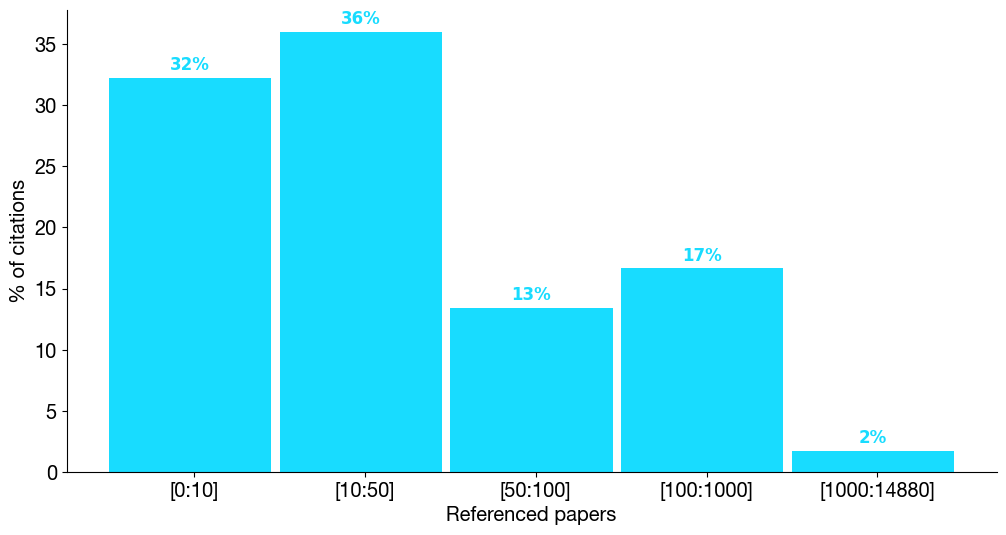

In [9]:
display_histogram(*generate_histogram_citations(load_predictions(["classic_methods/preds/semantic_scholar/acl"], keys=["citationCount"])[0]))

## Authors substitution analysis

In [10]:
trues = load_trues("../reading_lists.csv", keys=["id_title", "authors"], acl_only=True)
preds = load_predictions([
    "classic_methods/preds/semantic_scholar/acl",
], keys=["id_title", "authors"])
preds_names = ["Semantic Scholar - ACL"]

table = score_models(trues, preds, preds_names, split_by_years=False, metrics=[recall,recall_first_author,recall_any_authors]); table 

recall                                \
                              A1        A2        A3      Mean   
Semantic Scholar - ACL  8.649706  6.242661  10.47619  8.456186   

                       recall_first_author                                 \
                                        A1       A2         A3       Mean   
Semantic Scholar - ACL           14.143836  9.54501  16.906393  13.531746   

                       recall_any_authors                                   
                                       A1         A2         A3       Mean  
Semantic Scholar - ACL          27.589743  22.757764  33.602463  27.983323